In [1]:
import numpy as np
import pandas as pd
import random
import operator
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
import seaborn as sns
pd.options.mode.chained_assignment = None
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import kurtosis
from scipy.stats import skew

## Assets Plots

In [2]:
def load_data(ticker):
    df = pd.read_csv(f"data/{ticker}.csv")
    df["date"] = pd.to_datetime(df["date"])
    df.set_index(["date"], inplace=True)
    df = df.drop(["ticker", 'high', 'low'], axis=1).sort_index()
    return df

In [3]:
spx = load_data("SPX")
rus = load_data("RUS")
wti = load_data("WTI")
gold = load_data("GOLD")
spx.columns = ["spx"]
rus.columns = ["rus"]
wti.columns = ["wti"]
gold.columns = ["gold"]
spx_rus = pd.merge(spx, rus, on=["date"], how="inner")
spx_rus_wti = pd.merge(spx_rus, wti, on=["date"], how="inner")

# Prices
asset = pd.merge(spx_rus_wti, gold, on=["date"], how="inner")
asset = asset.iloc[251:]
dat = asset.iloc[np.where(asset.wti < 0)].index
asset = asset.drop(dat)

# Log Returns
log_return = asset.copy()
log_return["spx"] = log_return.spx.pct_change()
log_return["rus"] = log_return.rus.pct_change()
log_return["wti"] = log_return.wti.pct_change()
log_return["gold"] = log_return.gold.pct_change()
log_return = (log_return.replace((np.inf, -np.inf), np.nan).dropna())

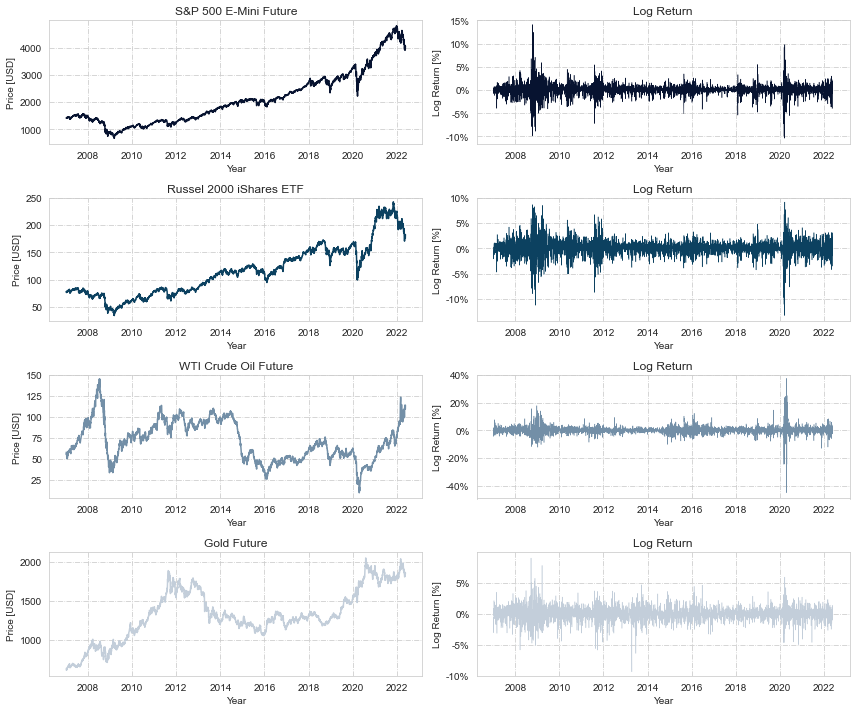

In [4]:
col = ["#071330", "#0C4160", "#738FA7", "#C3CEDA"]
asset_name = ["S&P 500 E-Mini Future", "Russel 2000 iShares ETF", "WTI Crude Oil Future", "Gold Future"]
sns.set_style("whitegrid", {'grid.linestyle': '-.'})
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))

for i in range(4):
    axes[i, 0].title.set_text(asset_name[i])
    axes[i, 0].set_xlabel("Year")
    axes[i, 0].set_ylabel("Price [USD]")

for j in range(4):
    axes[j, 1].title.set_text("Log Return")
    axes[j, 1].set_xlabel("Year")
    axes[j, 1].set_ylabel("Log Return [%]")
    axes[j, 1].yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

axes[0,0].plot(asset.spx, c = col[0], linewidth=1.5)
axes[0,1].plot(log_return.spx, c = col[0], linewidth=0.5)
axes[0,1].set_ylim(top = 0.15)

axes[1,0].plot(asset.rus, c = col[1])
axes[1,0].set_ylim(top = 250)
axes[1,1].plot(log_return.rus, c = col[1], linewidth=0.5)
axes[1,1].set_ylim(top = 0.10)

axes[2,0].plot(asset.wti, c = col[2])
axes[2,0].set_ylim(top = 150)
axes[2,1].plot(log_return.wti, c = col[2], linewidth=0.5)
axes[2,1].set_ylim(top = 0.4)

axes[3,0].plot(asset.gold, c = col[3])
axes[3,1].plot(log_return.gold, c = col[3], linewidth=0.5)
axes[3,1].set_ylim(bottom = -0.1)
fig.tight_layout()
#fig.savefig('svgs/data_return.svg', dpi = 1000)

<AxesSubplot:>

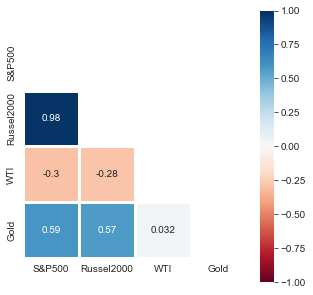

In [5]:
corr_asset = asset.copy()
corr_asset.columns = ["S&P500", "Russel2000", "WTI", "Gold"]
corr_asset = corr_asset.corr(method = "pearson")

mask = np.zeros_like(corr_asset)
mask[np.triu_indices_from(mask)] = True

sns.set_style("whitegrid", {'grid.linestyle': '-.'})
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(corr_asset, cmap = sns.color_palette("RdBu", as_cmap=True),
            vmax=1.0, vmin=-1.0 , mask = mask, ax = axes,
            linewidths=2.5, square = True, annot = True)
#fig.savefig('svgs/data_corr.svg', dpi = 1000)

In [6]:
stats = pd.DataFrame({"E(R)": (np.mean(log_return)*100*252).round(2).astype(str) + "%",
                      "std(R)":(np.std(log_return)*100*np.sqrt(252)).round(2).astype(str) + "%",
                      "Sharpe": ((np.mean(log_return)*252 )/ (np.std(log_return) * np.sqrt(252))).round(3),
                      "Skewness" : skew(log_return, bias = False).round(3),
                      "Kurtosis" : kurtosis(log_return, bias = False).round(3)})
stats.index = ["S&P500", "Russel2000", "WTI", "Gold"]
stats

,E(R),std(R),Sharpe,Skewness,Kurtosis
S&P500,8.94%,20.65%,0.433,-0.135,14.602
Russel2000,8.75%,25.35%,0.345,-0.410,6.555
WTI,15.02%,45.73%,0.328,-0.055,34.762
Gold,8.64%,17.98%,0.481,-0.135,5.696
